In [2]:
from os import listdir
from os.path import isfile, join
# from Utils import Load, Write
import pandas as pd
import numpy as np
from scipy import stats
# import math
import re
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
# from matplotlib import cm
# import plotly.plotly as py
from myplots import roundup, rounddown, find_decimal_fold, percentile_cut_off, rarefaction_calc, rarefaction_plot
from matplotlib.ticker import FormatStrFormatter
import cPickle as pickle
from Bio.SeqUtils import GC
from collections import Counter
import myplots
from myplots import calc_sig_corr

In [33]:
def get_sample_data(sample_name, generate_dfs): 
## this function generates dfs (general, only productive and only non productive) for each sample, and save
## as pickles. alternatively, it loads these dfs from pickles. 
    
    print 'getting sample data...'
    
    if generate_dfs:
        print 'generating'
        sample_df=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/%s.tsv" %sample_name)  
        sample_df_prod = sample_df[sample_df['sequenceStatus'] == 'In']
        sample_df_non_prod = sample_df[sample_df['sequenceStatus'] != 'In']
        
        pickle.dump(sample_df, open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_%s' %sample_name, "wb"))
        pickle.dump(sample_df_prod, open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_prod_%s' %sample_name, "wb"))
        pickle.dump(sample_df_non_prod, open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_non_prod_%s' %sample_name, "wb"))
    else:
        print 'loading'
        sample_df= pickle.load( open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_%s' %sample_name,"rb" ))
        sample_df_prod= pickle.load( open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_prod_%s' %sample_name,"rb" ))
        sample_df_non_prod= pickle.load( open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_non_prod_%s' %sample_name,"rb" ))
    
    print 'finished getting sample data'
    return sample_df, sample_df_prod, sample_df_non_prod


## Calculate shared sequences statistics for all samples:
##### better to run from eclipse: more updated, and send jobs to the clusters in parallel

In [4]:
def count_aa(df,total_unique_aa, sample_name):
    print('adding unique aas from sample %s...' %sample_name)
    list_aa=list(df['aminoAcid'])
    list_aa_new=[i for i in list_aa if isinstance(i, str)]
    sample_unique_aa=list(set(list_aa_new))
    print sample_unique_aa[:5]
    print total_unique_aa[:5]
    total_unique_aa=total_unique_aa+sample_unique_aa
    print total_unique_aa[:5]
    print len(total_unique_aa)
    return total_unique_aa

In [3]:
def get_sample_with_dfs():
    df_file_names = [f for f in listdir("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles") if isfile(join("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles", f))]
    df_file_names = [df_file for df_file in df_file_names if df_file.startswith ('sample_df_HIP')]
    samples_with_df=[s.replace("sample_df_", "") for s in df_file_names]
    return df_file_names,samples_with_df

In [6]:
def aa_counter(total_unique_aa):
    print'counting aa sequence occurence number...'
    aa_seq_counter_dic=Counter(total_unique_aa)
    print'finished counting aa sequence occurence number...'
    return aa_seq_counter_dic 
    

    
    

In [12]:
onlyfiles = [f for f in listdir("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/CSVfiles") if isfile(join("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/CSVfiles", f))]
onlyfiles = [datafile for datafile in onlyfiles if datafile.startswith ('HIP') and datafile.endswith('.csv')]
countfiles=0
sample_names=[re.sub('.csv', '', datafile) for datafile in onlyfiles] ## generate list of 
                                                                      ## sample names out 
                                                                      ##of the sample file names

generate_dfs=False ##False=load them from pickles, True=generate them.
df_file_names,samples_with_df=get_sample_with_dfs() ## check which samples have df
no_df_samples=[]
total_unique_aa_prod=[]
total_unique_aa_non_prod=[]


In [ ]:
for d in range(len(onlyfiles[:n_samples])): ##***change here for more sample!***
    countfiles=countfiles+1
    print countfiles
    sample_name=sample_names[d]
    print sample_name
## extract prod and non-prod dfs and calculate general parameters only for samples that
## have dfs:
    if sample_name not in samples_with_df:
        print('sample %s has no df' %sample_name)
    else:
        print('sample %s has df' %sample_name)
        sample_df, sample_df_prod, sample_df_non_prod=get_sample_data(sample_name, generate_dfs)
        total_unique_aa_prod=count_aa(sample_df_prod,total_unique_aa_prod,sample_name)
        total_unique_aa_non_prod=count_aa(sample_df_non_prod,total_unique_aa_non_prod,sample_name)


In [ ]:
pickle.dump(total_unique_aa_prod, open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/total_unique_aa_prod-n_samples-%s' %n_samples, "wb"))
prod_aa_seq_counter_dic=aa_counter(total_unique_aa_prod)
prod_aa_seq_counter_df=pd.DataFrame(prod_aa_seq_counter_dic.items(), columns=['aa_sequence', 'n_samples'])
pickle.dump(prod_aa_seq_counter_df, open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/prod_aa_seq_counter_df-n_samples-%s' %n_samples, "wb"))
print prod_aa_seq_counter_df
print prod_aa_seq_counter_df.groupby(['n_samples']).count()
pickle.dump(total_unique_aa_non_prod, open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/total_unique_aa_non_prod-n_samples-%s' %n_samples, "wb"))
non_prod_aa_seq_counter_dic=aa_counter(total_unique_aa_non_prod)
non_prod_aa_seq_counter_df=pd.DataFrame(non_prod_aa_seq_counter_dic.items(), columns=['aa_sequence', 'n_samples'])
pickle.dump(non_prod_aa_seq_counter_df, open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/non_prod_aa_seq_counter_df-n_samples-%s' %n_samples, "wb"))
print non_prod_aa_seq_counter_df
print non_prod_aa_seq_counter_df.groupby(['n_samples']).count()

In [53]:
non_prod_counter_grouped=non_prod_aa_seq_counter_df.groupby(['n_samples']).count()

In [58]:
prod_aa_seq_counter_dic=aa_counter(total_unique_aa_prod)

counting aa sequence occurence number...
finished counting aa sequence occurence number...


In [60]:
pickle.dump(prod_aa_seq_counter_df, open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/prod_aa_seq_counter_df-n_samples-%s' %n_samples, "wb"))

In [61]:
prod_aa_seq_counter_grouped=prod_aa_seq_counter_df.groupby(['n_samples']).count()

In [62]:
print prod_aa_seq_counter_grouped[:20]

           aa_sequence
n_samples             
1             48396306
2              4437393
3              1631229
4               845658
5               515867
6               346356
7               248490
8               186890
9               145267
10              115855
11               94978
12               79084
13               65851
14               56437
15               49331
16               42390
17               37433
18               32947
19               29708
20               26659


In [63]:
print prod_aa_seq_counter_grouped[-20:]

           aa_sequence
n_samples             
540                  4
541                  2
542                  5
543                  9
544                  2
545                  7
546                  3
547                  3
548                  8
549                  9
550                  3
551                  4
552                  3
553                  1
554                  4
555                  5
556                  4
557                  3
558                  2
559                  1


In [66]:
pickle.dump(prod_aa_seq_counter_grouped, open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/prod_aa_seq_counter_grouped-n_samples-%s' %n_samples, "wb"))

In [69]:
pickle.dump(total_unique_aa_non_prod, open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/total_unique_aa_non_prod-n_samples-%s' %n_samples, "wb"))


In [70]:
non_prod_aa_seq_counter_dic=aa_counter(total_unique_aa_non_prod)


counting aa sequence occurence number...
finished counting aa sequence occurence number...


In [71]:
non_prod_aa_seq_counter_df=pd.DataFrame(non_prod_aa_seq_counter_dic.items(), columns=['aa_sequence', 'n_samples'])


In [72]:
pickle.dump(non_prod_aa_seq_counter_df, open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/non_prod_aa_seq_counter_df-n_samples-%s' %n_samples, "wb"))

In [74]:
non_prod_aa_seq_counter_grouped=non_prod_aa_seq_counter_df.groupby(['n_samples']).count()

In [76]:
print non_prod_aa_seq_counter_grouped[-20:]

           aa_sequence
n_samples             
36                   3
37                   4
38                   3
39                   4
40                   3
41                   2
44                   2
45                   1
48                   1
51                   1
55                   1
61                   1
62                   1
65                   1
69                   1
70                   1
82                   1
88                   1
128                  1
161                  1


In [ ]:
print non_prod_aa_seq_counter_grouped[:20]

## plotting distributions of shared samples per aa sequence:

In [510]:
### load the GROUPED productive sequence counter 

with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/prod_aa_seq_counter_grouped-n_samples-573','rb') as f:
    prod_aa_seq_counter_grouped573=pickle.load(f)
f.close()

In [517]:
### load the full productive sequence counter *** HUGE FILE!! ***

with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/prod_aa_seq_counter_df','rb') as f:
    prod_aa_seq_counter_df=pickle.load(f)
f.close()

In [481]:
prod_aa_seq_counter_grouped573.head()

aa_sequence
n_samples             
1             48396306
2              4437393
3              1631229
4               845658
5               515867

In [514]:
prod_aa_seq_counter_grouped573.tail()

aa_sequence
n_samples             
555                  5
556                  4
557                  3
558                  2
559                  1

In [511]:
prod_n_samples=list(prod_aa_seq_counter_grouped573.index)

In [512]:
prod_public_counter=list(prod_aa_seq_counter_grouped573['aa_sequence'])

In [488]:
### load the GROUPED NON productive sequence counter 

with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/non_prod_aa_seq_counter_grouped','rb') as f:
    non_prod_aa_seq_counter_grouped=pickle.load(f)
f.close()

In [528]:
### load the full non productive sequence counter ***BIG FILE!***

with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/non_prod_aa_seq_counter_df-n_samples-573','rb') as f:
    non_prod_aa_seq_counter_df=pickle.load(f)
f.close()


In [491]:
non_prod_aa_seq_counter_grouped.head()

aa_sequence
n_samples             
1              1984245
2                35236
3                 7875
4                 3158
5                 1564

In [513]:
non_prod_aa_seq_counter_grouped.tail()

aa_sequence
n_samples             
70                   1
82                   1
88                   1
128                  1
161                  1

In [508]:
non_prod_n_samples=list(non_prod_aa_seq_counter_grouped.index)

In [509]:
non_prod_public_counter=list(non_prod_aa_seq_counter_grouped['aa_sequence'])

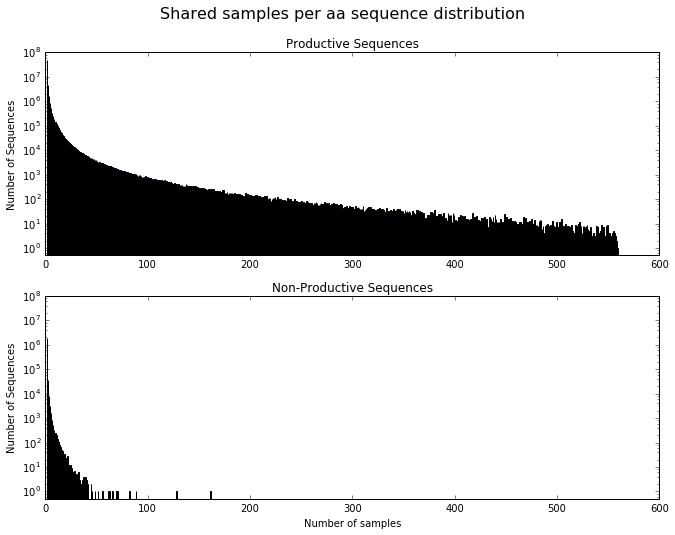

In [504]:
prod_public_dist_fig=plt.figure(figsize=(11,8))
plt.suptitle('Shared samples per aa sequence distribution', fontsize=16)
plt.subplot(2,1,1)
plt.bar(prod_n_samples,prod_public_counter, color='blue')
plt.yscale('log')
plt.ylim(0.5,10**8)
plt.xlim(0,600)
plt.title('Productive Sequences')
plt.ylabel('Number of Sequences')
plt.subplot(2,1,2)
plt.bar(non_prod_n_samples,non_prod_public_counter, color='red')
plt.yscale('log')
plt.ylim(0.5,10**8)
plt.xlim(0,600)
plt.title('Non-Productive Sequences')
plt.xlabel('Number of samples')
plt.ylabel('Number of Sequences')

plt.show()

In [505]:
with PdfPages('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Images/Shared samples per aa sequence distribution.pdf') as pdf:
    pdf.savefig(prod_public_dist_fig)
pdf.close

<bound method PdfPages.close of <matplotlib.backends.backend_pdf.PdfPages object at 0x7f2266101cd0>>

#### calculate statistics:

In [519]:
prod_aa_seq_counter_df.head()

aa_sequence  n_samples
0      CASRTQGSNYEQYF          1
1     CASSEDVRLNQPQHF          1
2  CSAHPVTGSGTSTDTQYF          1
3      CASSPEGTDPWNTF          1
4    CASSLSQRGYYNEQFF          2

In [529]:
non_prod_aa_seq_counter_df.head()

aa_sequence  n_samples
0      CASESG*GVGSPLHF          1
1    CASSDFDAGQP*ETQYF          1
2  CASSPD*REESSNTGELFF          1
3      CASSQF*EELTEAFF          1
4       CSAMG*RGGDTQYF          1

In [524]:
MeanSharedProd=prod_aa_seq_counter_df['n_samples'].mean()
print MeanSharedProd

1.83554524686


In [530]:
MeanSharedNonProd=non_prod_aa_seq_counter_df['n_samples'].mean()
print MeanSharedNonProd

1.04536254111


In [531]:
MaxSharedNonProd=non_prod_aa_seq_counter_df['n_samples'].max()
print MaxSharedNonProd

161


In [541]:
print perc_public(prod_aa_seq_counter_df)
print perc_public(non_prod_aa_seq_counter_df)

16.2689727536
2.49328864172


In [542]:
print public10perc(prod_aa_seq_counter_df)
print public10perc(non_prod_aa_seq_counter_df)

0.184324396821
0.00044226413685


In [543]:
print public50perc(prod_aa_seq_counter_df)
print public50perc(non_prod_aa_seq_counter_df)

0.00927340004091
0.0


In [544]:
print public95perc(prod_aa_seq_counter_df)
print public95perc(non_prod_aa_seq_counter_df)

0.000103806716876
0.0


In [545]:
print meanSharedSamples(prod_aa_seq_counter_df)
print meanSharedSamples(non_prod_aa_seq_counter_df)

1.83554524686
1.04536254111


In [547]:
print len(prod_aa_seq_counter_df)
print len(non_prod_aa_seq_counter_df)

57799728
2034983


## Merge sharing information to each sample df:

#### better to run from eclipse: more updated, and send jobs to the clusters in parallel

In [37]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/prod_aa_seq_counter_df-n_samples-573','rb') as f:
    prod_aa_seq_counter_df=pickle.load(f)
f.close()

In [75]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/non_prod_aa_seq_counter_df-n_samples-573','rb') as f:
    non_prod_aa_seq_counter_df=pickle.load(f)
f.close()

In [40]:
prod_aa_seq_counter_df.set_index('aa_sequence', inplace=True)
prod_aa_seq_counter_df.head()

n_samples
aa_sequence                  
CASRTQGSNYEQYF              1
CASSEDVRLNQPQHF             1
CSAHPVTGSGTSTDTQYF          1
CASSPEGTDPWNTF              1
CASSLSQRGYYNEQFF            2

In [82]:
non_prod_aa_seq_counter_df.set_index('aa_sequence', inplace=True)
non_prod_aa_seq_counter_df.head()

n_samples
aa_sequence                   
CASESG*GVGSPLHF              1
CASSDFDAGQP*ETQYF            1
CASSPD*REESSNTGELFF          1
CASSQF*EELTEAFF              1
CSAMG*RGGDTQYF               1

In [173]:
n_samples=573


In [ ]:
### the following code generate the dfs with the sharing information for each sequence, and also calculate public statistics
## for each sample and combine it to summarizing df.
## an updated and clean version, that sends jobs to the queue in parallel, is available in eclipse


n=1
df_n=2
save_pickles=True
public_func_list=[perc_public, public10perc, public50perc, public95perc, meanSharedSamples, cdr3PriToPub, cdr3PriToPub95]
public_result_df=generate_res_DF(sample_names, public_func_list, df_n)

for d in range(len(samples_with_df[:n_samples])): ##***change here for more samples!***
    sample_name=samples_with_df[d]
    print n
    print sample_name
## extract prod and non-prod dfs: 
    sample_df, sample_df_prod, sample_df_non_prod=get_sample_data(sample_name, generate_dfs)
    sample_df_prod_wityPublic, sample_df_prod_wityPublic_grouped=add_public(sample_df_prod,'prod')
    sample_df_non_prod_wityPublic, sample_df_non_prod_wityPublic_grouped=add_public(sample_df_non_prod,'non_prod')
    if save_pickles:
        with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_prod_wityPublic_%s' %sample_name,'wb') as f1:
            pickle.dump(sample_df_prod_wityPublic,f1)
        f1.close()
        with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_prod_wityPublic_grouped_%s' %sample_name,'wb') as f2:
            pickle.dump(sample_df_prod_wityPublic_grouped,f2)
        f2.close()
        with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_non_prod_wityPublic_%s' %sample_name,'wb') as f3:
            pickle.dump(sample_df_non_prod_wityPublic,f3)
        f3.close()
        with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_non_prod_wityPublic_grouped_%s' %sample_name,'wb') as f4:
            pickle.dump(sample_df_non_prod_wityPublic_grouped,f4)
        f4.close()
    public_result_df=calculate_public_res_df(public_result_df,public_func_list, sample_name, sample_df_prod_wityPublic_grouped, sample_df_non_prod_wityPublic_grouped)
    n=n+1
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/public_res_df_%s_samples' %n_samples, "wb") as f5:
    pickle.dump(public_result_df, f5)    
f5.close() 

    

In [165]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/public_res_df_%s_samples' %n_samples, "wb") as f5:
    pickle.dump(public_result_df, f5)    
f5.close()

In [268]:
def add_public(df,counter_df):
    sample_df_wityPublic=pd.merge(df, counter_df, how='inner', left_on='aminoAcid', right_index=True,
         suffixes=('_x', '_y'), copy=True, indicator=True)
    sample_df_wityPublic['shareStatus']=np.where(sample_df_wityPublic['n_samples']>1, 1, 0)
    sample_df_wityPublic_grouped=sample_df_wityPublic.groupby('aminoAcid').mean()
    columns_to_keep=['count (reads)', 'frequencyCount (%)', 'cdr3Length', 'vDeletion', 'n1Insertion', 'd5Deletion', 'd3Deletion', 'n2Insertion', 'jDeletion', 'vIndex', 'n1Index',
                     'dIndex','n2Index', 'jIndex', 'estimatedNumberGenomes', 'fractionNucleated', 'n_samples', 'shareStatus']
    sample_df_wityPublic_grouped=sample_df_wityPublic_grouped[columns_to_keep]
    
    return sample_df_wityPublic, sample_df_wityPublic_grouped
   
    

In [159]:
def calculate_public_res_df(result_df,function_list, sample_name, sample_df_prod_wityPublic_grouped, sample_df_non_prod_wityPublic_grouped):
    print 'calculating public results....'
    ind=0
    df_list=[sample_df_prod_wityPublic_grouped, sample_df_non_prod_wityPublic_grouped] ## df list is generated here and doesnt come 
                                                 ## as input as it contains the specfic dfs
                                                 ##for each sample   
    
    for j, func in enumerate(function_list):
        for i, df in enumerate(df_list):
            result=func(df)
            result_df.loc[sample_name, result_df.columns[ind]]=result
            ind+=1
    print 'finished calculating results....'
    return result_df

In [281]:
def generate_res_DF(sample_names, function_list, df_n):
    print 'generating result dataframe...'
    result_df=pd.DataFrame({'Sample': sample_names})
    result_df=result_df.set_index('Sample')
    function_names=[f.__name__ for f in function_list]
    for function in function_names:
        for i in range(df_n):
            col_title=function+'_df_%s' %str(i)
            result_df[col_title]=np.NaN
    print 'finished generating result dataframe'
    return result_df

In [532]:
## public population functions:


def perc_public(df):
    n_public=len(df[df['n_samples']>1])
    perc_public=(float(n_public)/len(df['n_samples']))*100
    return perc_public

def public10perc(df):
    n_public10=len(df[df['n_samples']>57])
    perc_public10=(float(n_public10)/len(df['n_samples']))*100
    return perc_public10

def public50perc(df):
    n_public50=len(df[df['n_samples']>286])
    perc_public50=(float(n_public50)/len(df['n_samples']))*100
    return perc_public50

def public95perc(df):
    n_public95=len(df[df['n_samples']>544])
    perc_public95=(float(n_public95)/len(df['n_samples']))*100
    return perc_public95

def meanSharedSamples(df):
    mean_shared=df['n_samples'].mean()
    return mean_shared

def cdr3PriToPub(df):
    mean_cdr3_pri=df[df['n_samples']==1]['cdr3Length'].mean()
    mean_cdr3_pub=df[df['n_samples']>1]['cdr3Length'].mean()
    cdr3PriToPub=float(mean_cdr3_pri)/mean_cdr3_pub
    return cdr3PriToPub

def cdr3PriToPub95(df):
    mean_cdr3_pri=df[df['n_samples']==1]['cdr3Length'].mean()
    mean_cdr3_pub95=df[df['n_samples']>544]['cdr3Length'].mean()
    cdr3PriToPub95=float(mean_cdr3_pri)/mean_cdr3_pub95
    return cdr3PriToPub95

In [104]:
sample_df_prod_wityPublic_grouped. groupby('n_samples').count()

count (reads)  frequencyCount (%)  cdr3Length  vDeletion  \
n_samples                                                             
1.0                86054               86054       86054      86054   
2.0                16565               16565       16565      16565   
3.0                 9143                9143        9143       9143   
4.0                 6400                6400        6400       6400   
5.0                 4970                4970        4970       4970   
6.0                 3952                3952        3952       3952   
7.0                 3343                3343        3343       3343   
8.0                 2888                2888        2888       2888   
9.0                 2492                2492        2492       2492   
10.0                2202                2202        2202       2202   
11.0                2035                2035        2035       2035   
12.0                1841                1841        1841       1841   
13.0                1720                1720        1720       1720   
14.0                1556                1556        1556       1556   
15.0                1436                1436        1436       1436   
16.0                1265                1265        1265       1265   
17.0                1227                1227        1227       1227   
18.0                1137                1137        1137       1137   
19.0                1093                1093        1093       1093   
20.0                1020                1020        1020       1020   
21.0                 974                 974         974        974   
22.0                 938                 938         938        938   
23.0                 846                 846         846        846   
24.0                 828                 828         828        828   
25.0                 764                 764         764        764   
26.0                 754                 754         754        754   
27.0                 726                 726         726        726   
28.0                 747                 747         747        747   
29.0                 621                 621         621        621   
30.0                 618                 618         618        618   
...                  ...                 ...         ...        ...   
530.0                  6                   6           6          6   
531.0                  5                   5           5          5   
532.0                  7                   7           7          7   
533.0                  3                   3           3          3   
534.0                  2                   2           2          2   
535.0                  3                   3           3          3   
536.0                  2                   2           2          2   
537.0                  3                   3           3          3   
538.0                  8                   8           8          8   
539.0                  7                   7           7          7   
540.0                  4                   4           4          4   
541.0                  1                   1           1          1   
542.0                  5                   5           5          5   
543.0                  8                   8           8          8   
544.0                  2                   2           2          2   
545.0                  7                   7           7          7   
546.0                  3                   3           3          3   
547.0                  3                   3           3          3   
548.0                  8                   8           8          8   
549.0                  9                   9           9          9   
550.0                  3                   3           3          3   
551.0                  4                   4           4          4   
552.0                  3                   3           3          3   
553.0                  1           

In [121]:
sample_df_non_prod_wityPublic_grouped. groupby('n_samples').count()

count (reads)  frequencyCount (%)  cdr3Length  vDeletion  \
n_samples                                                             
1.0                 4166                4166        4166       4166   
2.0                  159                 159         159        159   
3.0                   56                  56          56         56   
4.0                   29                  29          29         29   
5.0                   16                  16          16         16   
6.0                    9                   9           9          9   
7.0                    7                   7           7          7   
8.0                    5                   5           5          5   
9.0                    5                   5           5          5   
10.0                   3                   3           3          3   
11.0                   3                   3           3          3   
12.0                   6                   6           6          6   
13.0                   3                   3           3          3   
14.0                   5                   5           5          5   
16.0                   2                   2           2          2   
17.0                   2                   2           2          2   
18.0                   2                   2           2          2   
19.0                   2                   2           2          2   
20.0                   3                   3           3          3   
23.0                   1                   1           1          1   
40.0                   2                   2           2          2   
41.0                   1                   1           1          1   
51.0                   1                   1           1          1   
82.0                   1                   1           1          1   
88.0                   1                   1           1          1   

           n1Insertion  d5Deletion  d3Deletion  n2Insertion  jDeletion  \
n_samples                                                                
1.0               4166        4166        4166         4166       4166   
2.0                159         159         159          159        159   
3.0                 56          56          56           56         56   
4.0                 29          29          29           29         29   
5.0                 16          16          16           16         16   
6.0                  9           9           9            9          9   
7.0                  7           7           7            7          7   
8.0                  5           5           5            5          5   
9.0                  5           5           5            5          5   
10.0                 3           3           3            3          3   
11.0                 3           3           3            3          3   
12.0                 6           6           6            6          6   
13.0                 3           3           3            3          3   
14.0                 5           5           5            5          5   
16.0                 2           2           2            2          2   
17.0                 2           2           2            2          2   
18.0                 2           2           2            2          2   
19.0                 2           2           2            2          2   
20.0                 3           3           3            3          3   
23.0                 1           1           1            1          1   
40.0                 2           2           2            2          2   
41.0                 1           1           1            1          1   
51.0                 1           1           1            1          1   
82.0                 1           1           1            1          1   
88.0                 1           1           1            1          1   

           vIndex  n1Index  dIndex  n2Index  jIndex  estimatedNumberGenomes  \
n_samples      

In [105]:
sample_df_prod_wityPublic.groupby('_merge').count()

nucleotide  aminoAcid  count (reads)  frequencyCount (%)  \
_merge                                                                 
left_only            0          0              0                   0   
right_only           0          0              0                   0   
both            215813     215813         215813              215813   

            cdr3Length  vMaxResolved  vFamilyName  vGeneName  vGeneAllele  \
_merge                                                                      
left_only            0             0            0          0            0   
right_only           0             0            0          0            0   
both            215813        215813       215647     215813       137238   

            vFamilyTies     ...       cloneResolved  vOrphon  dOrphon  \
_merge                      ...                                         
left_only             0     ...                   0        0        0   
right_only            0     ...                   0        0        0   
both                166     ...              215813        0        0   

            jOrphon  vFunction  dFunction  jFunction  fractionNucleated  \
_merge                                                                    
left_only         0          0          0          0                  0   
right_only        0          0          0          0                  0   
both              0          0          0          0             215813   

            n_samples  shareStatus  
_merge                              
left_only           0            0  
right_only          0            0  
both           215813       215813  

[3 rows x 49 columns]

In [50]:
merged_sample_df_prod=pd.merge(sample_df_prod, prod_aa_seq_counter_df, how='inner', left_on='aminoAcid', right_index=True,
         suffixes=('_x', '_y'), copy=True, indicator=True)


## TRIAL ANALYSIS:###

#### 3 trial files with 499 sequences are used to test the public analysis pipeline

In [176]:
sample_names_trial=['Trial1', 'Trial2', 'Trial3']

In [ ]:
# generate a list of unique aa sequences in each trial file

total_unique_aa_prod=[]
total_unique_aa_non_prod=[]
for sample in sample_names_trial:
    print sample
    sample_df, sample_df_prod, sample_df_non_prod=get_sample_data(sample, True)
    total_unique_aa_prod=count_aa(sample_df_prod,total_unique_aa_prod,sample_name)
    total_unique_aa_non_prod=count_aa(sample_df_non_prod,total_unique_aa_non_prod,sample_name)
    print len(total_unique_aa_prod)+len(total_unique_aa_non_prod)
    

In [178]:
# save the lists of unique aa sequences in pickles

with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/total_unique_aa_prod-trial',"wb") as f1:
    pickle.dump(total_unique_aa_prod, f1)
f1. close()

# count in how manu samples each aa sequence appears, and save counter to pickle:
prod_aa_seq_counter_dic=aa_counter(total_unique_aa_prod)
prod_aa_seq_counter_df=pd.DataFrame(prod_aa_seq_counter_dic.items(), columns=['aa_sequence', 'n_samples'])

with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/prod_aa_seq_counter_df-trial', "wb") as f2:
    pickle.dump(prod_aa_seq_counter_df, f2)
f2.close()

counting aa sequence occurence number...
finished counting aa sequence occurence number...


In [180]:
## as expected, 4 aa sequences appear in 2 trial samples, and the other sequences appear in only one sample

#prod_aa_seq_counter_df. groupby('n_samples').count()

aa_sequence
n_samples             
1                 1202
2                    4

In [181]:
# repeat this analysis for non productive sequences:

with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/total_unique_aa_non_prod-trial',"wb") as f1:
    pickle.dump(total_unique_aa_non_prod, f1)
f1. close()
non_prod_aa_seq_counter_dic=aa_counter(total_unique_aa_non_prod)
non_prod_aa_seq_counter_df=pd.DataFrame(non_prod_aa_seq_counter_dic.items(), columns=['aa_sequence', 'n_samples'])

with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/non_prod_aa_seq_counter_df-trial', "wb") as f2:
    pickle.dump(non_prod_aa_seq_counter_df, f2)
f2.close()

counting aa sequence occurence number...
finished counting aa sequence occurence number...


In [182]:
non_prod_aa_seq_counter_df. groupby('n_samples').count()

aa_sequence
n_samples             
1                   25

In [183]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/total_unique_aa_prod-n_samples-573',"rb") as f1:
    total_unique_aa_prod=pickle.load(f1)
f1. close()

In [186]:
# now generate a list of aa sequences and test in how many samples they appear:


seqList=["CASSDSSGSYNEQFF",
"CASSLQGNTEAFF",
"CASSVGGSGNTIYF",
"CASTPGSSTEAFF",
"CAARGGEGGQPQHF",
"CACPGVTYGYTF",
"CAGQWRGNQPQHF",
"CAGRTGGNTIYF",
"CAHKHETGGTEAFF",
"CAIDTGDQPQHF",
"CAIFARDRYTEAFF",
"CAIGGGQASTDTQYF",
"CAIGVGGPTGNTIYF",
"CAIPGGTDTQYF",
"CAIRDRMNTEAFF",
"CAIREGAASTNEKLFF",
"CAIRGDTEAFF",
"CAIRGGGTEAFF",
"CAIRSDRGDNEQFF",
"CAIRSGDQPQHF",
]

In [188]:
n_samples_list=[total_unique_aa_prod.count(seq) for seq in seqList]
    

In [189]:
# as expected, about half appear in more than one sample:
print n_samples_list

[292, 549, 415, 5, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 18, 1, 41, 28, 1, 5]


In [190]:
#repeat with another list of sequences, this time generated randomly: 

rand_seqs=np.random.choice(total_unique_aa_prod, 20, replace=False)

In [192]:
n_samples_list2=[total_unique_aa_prod.count(seq) for seq in rand_seqs]

In [193]:
# again, about half of the sequences appear in more than 1 sample:
print n_samples_list2

[36, 14, 15, 2, 272, 1, 1, 31, 1, 8, 1, 1, 1, 1, 173, 1, 1, 3, 2, 1]


In [196]:
sum(1 for i in n_samples_list if i==1)

11

In [194]:
sum(1 for i in n_samples_list2 if i==1)

10

In [197]:
sum(1 for i in n_samples_list if i>57)

3

In [195]:
sum(1 for i in n_samples_list2 if i>57)

2

In [198]:
#repeat this analysis again: 

rand_seqs3=np.random.choice(total_unique_aa_prod, 20, replace=False)

In [199]:
n_samples_list3=[total_unique_aa_prod.count(seq) for seq in rand_seqs3]

In [200]:
sum(1 for i in n_samples_list3 if i==1)

10

In [201]:
sum(1 for i in n_samples_list3 if i>57)

6

In [208]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_prod_wityPublic_HIP04510', 'rb') as f1:
    sample_df_prod_wityPublic_HIP04510= pickle.load(f1)
f1.close()         

In [209]:
sample_df_prod_wityPublic_HIP04510.head()

nucleotide         aminoAcid  \
0     CGCACAGAGCAGGGGGACTCGGCCATGTATCTCTGTGCCAGCAGCT...  CASSLKGQGITGELFF   
1540  CGCACAGAGCGGGGGGACTCAGCCGTGTATCTCTGTGCCAGCAGCT...  CASSLKGQGITGELFF   
1599  CGCACACAGCAGGAGGACTCGGCCGTGTATCTCTGTGCCAGCAGCT...  CASSLKGQGITGELFF   
2308  CCTGCAGAGCTTGGGGACTCGGCCATGTATCTCTGTGCCAGCAGCT...  CASSLKGQGITGELFF   
3001  CGCACACAGCAGGAGGACTCGGCCATGTATCTCTGTGCCAGCAGCT...  CASSLKGQGITGELFF   

      count (reads)  frequencyCount (%)  cdr3Length   vMaxResolved  \
0            431856            4.840893          48     TCRBV07-09   
1540            421            0.004719          48  TCRBV07-03*01   
1599            406            0.004551          48  TCRBV07-02*01   
2308            297            0.003329          48  TCRBV11-01*01   
3001            237            0.002657          48  TCRBV07-02*01   

     vFamilyName   vGeneName  vGeneAllele vFamilyTies     ...     vOrphon  \
0        TCRBV07  TCRBV07-09          NaN         NaN     ...         NaN   
1540     TCRBV07  TCRBV07-03          1.0         NaN     ...         NaN   
1599     TCRBV07  TCRBV07-02          1.0         NaN     ...         NaN   
2308     TCRBV11  TCRBV11-01          1.0         NaN     ...         NaN   
3001     TCRBV07  TCRBV07-02          1.0         NaN     ...         NaN   

     dOrphon jOrphon vFunction dFunction  jFunction fractionNucleated  \
0        NaN     NaN       NaN       NaN        NaN          0.112682   
1540     NaN     NaN       NaN       NaN        NaN          0.000110   
1599     NaN     NaN       NaN       NaN        NaN          0.000106   
2308     NaN     NaN       NaN       NaN        NaN          0.000077   
3001     NaN     NaN       NaN       NaN        NaN          0.000062   

     n_samples _merge shareStatus  
0            6   both           1  
1540         6   both           1  
1599         6   both           1  
2308         6   both           1  
3001         6   both           1  

[5 rows x 50 columns]

In [210]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_prod_wityPublic_grouped_HIP04510', 'rb') as f1:
    sample_df_prod_wityPublic_grouped_HIP04510= pickle.load(f1)
f1.close()

In [211]:
sample_df_prod_wityPublic_grouped_HIP04510.head()

count (reads)  frequencyCount (%)  cdr3Length  vDeletion  \
aminoAcid                                                                     
ADRQYQPQHF                  25.0            0.000280        30.0       18.0   
AGRFSNQPQHF                 35.0            0.000392        33.0       26.0   
APAVDSPGEPGENIQYF            8.0            0.000090        51.0       22.0   
AQHCNNEQFF                  38.0            0.000426        30.0       21.0   
CAAAGAGSYNEQFF              24.0            0.000269        42.0       12.0   

                   n1Insertion  d5Deletion  d3Deletion  n2Insertion  \
aminoAcid                                                             
ADRQYQPQHF                 4.0         2.0         4.0          4.0   
AGRFSNQPQHF                9.0         7.0         3.0          6.0   
APAVDSPGEPGENIQYF         25.0         8.0         2.0          9.0   
AQHCNNEQFF                 3.0         8.0         0.0         11.0   
CAAAGAGSYNEQFF             9.0         6.0         3.0          0.0   

                   jDeletion  vIndex  n1Index  dIndex  n2Index  jIndex  \
aminoAcid                                                                
ADRQYQPQHF               5.0    51.0     50.0    54.0     60.0    64.0   
AGRFSNQPQHF              1.0    48.0     39.0    48.0     54.0    60.0   
APAVDSPGEPGENIQYF        5.0    30.0     24.0    49.0     55.0    64.0   
AQHCNNEQFF               5.0    51.0     46.0    49.0     53.0    64.0   
CAAAGAGSYNEQFF           1.0    39.0     44.0    53.0     -1.0    60.0   

                   estimatedNumberGenomes  fractionNucleated  n_samples  \
aminoAcid                                                                 
ADRQYQPQHF                            1.0           0.000007        1.0   
AGRFSNQPQHF                           2.0           0.000009        1.0   
APAVDSPGEPGENIQYF                     4.0           0.000002        1.0   
AQHCNNEQFF                            2.0           0.000010        1.0   
CAAAGAGSYNEQFF                        1.0           0.000006        1.0   

                   shareStatus  
aminoAcid                       
ADRQYQPQHF                 0.0  
AGRFSNQPQHF                0.0  
APAVDSPGEPGENIQYF          0.0  
AQHCNNEQFF                 0.0  
CAAAGAGSYNEQFF             0.0

In [212]:
sample_df_prod_wityPublic_grouped_HIP04510.tail()

count (reads)  frequencyCount (%)  cdr3Length  vDeletion  \
aminoAcid                                                                     
YPPKRRTHYLPNYGYTF            2.0            0.000022        51.0       16.0   
YRGPLGNQPQHF                33.0            0.000370        36.0       16.0   
YSARGDRDRGGYTF               2.0            0.000022        42.0        7.0   
YSARPFTGSNEKLFF              2.0            0.000022        45.0        5.0   
YSSPRPRGDGNQPQHF            22.0            0.000247        48.0        5.0   

                   n1Insertion  d5Deletion  d3Deletion  n2Insertion  \
aminoAcid                                                             
YPPKRRTHYLPNYGYTF         15.0         1.0         6.0         12.0   
YRGPLGNQPQHF               6.0         7.0         4.0          7.0   
YSARGDRDRGGYTF             6.0         0.0         3.0          7.0   
YSARPFTGSNEKLFF            9.0         3.0         4.0          2.0   
YSSPRPRGDGNQPQHF           9.0         8.0         3.0          5.0   

                   jDeletion  vIndex  n1Index  dIndex  n2Index  jIndex  \
aminoAcid                                                                
YPPKRRTHYLPNYGYTF        2.0    30.0     31.0    46.0     51.0    63.0   
YRGPLGNQPQHF             2.0    45.0     43.0    49.0     54.0    61.0   
YSARGDRDRGGYTF           7.0    39.0     46.0    52.0     61.0    68.0   
YSARPFTGSNEKLFF          3.0    36.0     45.0    54.0     59.0    61.0   
YSSPRPRGDGNQPQHF         2.0    33.0     42.0    51.0     56.0    61.0   

                   estimatedNumberGenomes  fractionNucleated  n_samples  \
aminoAcid                                                                 
YPPKRRTHYLPNYGYTF                     1.0       5.200000e-07        1.0   
YRGPLGNQPQHF                          3.0       8.610000e-06        1.0   
YSARGDRDRGGYTF                        1.0       5.200000e-07        1.0   
YSARPFTGSNEKLFF                       1.0       5.200000e-07        1.0   
YSSPRPRGDGNQPQHF                      1.0       5.740000e-06        1.0   

                   shareStatus  
aminoAcid                       
YPPKRRTHYLPNYGYTF          0.0  
YRGPLGNQPQHF               0.0  
YSARGDRDRGGYTF             0.0  
YSARPFTGSNEKLFF            0.0  
YSSPRPRGDGNQPQHF           0.0

In [213]:
sample_df_prod_wityPublic_grouped_HIP04510.groupby('n_samples').count()

count (reads)  frequencyCount (%)  cdr3Length  vDeletion  \
n_samples                                                             
1.0                46432               46432       46432      46432   
2.0                 8478                8478        8478       8478   
3.0                 4750                4750        4750       4750   
4.0                 3253                3253        3253       3253   
5.0                 2446                2446        2446       2446   
6.0                 2048                2048        2048       2048   
7.0                 1713                1713        1713       1713   
8.0                 1454                1454        1454       1454   
9.0                 1289                1289        1289       1289   
10.0                1080                1080        1080       1080   
11.0                 914                 914         914        914   
12.0                 911                 911         911        911   
13.0                 801                 801         801        801   
14.0                 692                 692         692        692   
15.0                 690                 690         690        690   
16.0                 675                 675         675        675   
17.0                 565                 565         565        565   
18.0                 546                 546         546        546   
19.0                 507                 507         507        507   
20.0                 508                 508         508        508   
21.0                 460                 460         460        460   
22.0                 455                 455         455        455   
23.0                 427                 427         427        427   
24.0                 386                 386         386        386   
25.0                 412                 412         412        412   
26.0                 363                 363         363        363   
27.0                 351                 351         351        351   
28.0                 311                 311         311        311   
29.0                 338                 338         338        338   
30.0                 317                 317         317        317   
...                  ...                 ...         ...        ...   
530.0                  4                   4           4          4   
531.0                  5                   5           5          5   
532.0                  6                   6           6          6   
533.0                  3                   3           3          3   
534.0                  2                   2           2          2   
535.0                  2                   2           2          2   
536.0                  2                   2           2          2   
537.0                  3                   3           3          3   
538.0                  8                   8           8          8   
539.0                  7                   7           7          7   
540.0                  3                   3           3          3   
541.0                  2                   2           2          2   
542.0                  5                   5           5          5   
543.0                  9                   9           9          9   
544.0                  2                   2           2          2   
545.0                  6                   6           6          6   
546.0                  3                   3           3          3   
547.0                  3                   3           3          3   
548.0                  6                   6           6          6   
549.0                  9                   9           9          9   
550.0                  3                   3           3          3   
551.0                  4                   4           4          4   
552.0                  3                   3           3          3   
553.0                  1           

In [217]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/public_analysis/calculate_public_stats/public_analysis_results_df_10_20', 'rb') as f1:
    public_analysis_results_df_10_20= pickle.load(f1)
f1.close()



In [219]:
public_analysis_results_df_10_20

perc_public_df_0  perc_public_df_1  public10perc_df_0  \
Sample                                                            
HIP14134         52.807704          4.529494          11.828268   
HIP14039         54.146869          6.970598          12.557464   
HIP13933         56.282980          6.804511          13.768842   
HIP14237         54.754529          5.832390          13.637766   
HIP14240         53.189761          6.657819          11.577895   
HIP11717         60.542440          7.432981          14.950845   
HIP11784         56.985657          6.805399          14.274058   
HIP02663         55.030412          6.357143          13.130983   
HIP13939         54.660080          7.401539          12.143446   
HIP14911         54.664748          6.509217          12.193578   

          public10perc_df_1  public50perc_df_0  public50perc_df_1  \
Sample                                                              
HIP14134           0.140449           2.053180                0.0   
HIP14039           0.099108           2.203803                0.0   
HIP13933           0.000000           2.634615                0.0   
HIP14237           0.056625           2.681603                0.0   
HIP14240           0.000000           1.716926                0.0   
HIP11717           0.081235           2.709603                0.0   
HIP11784           0.000000           2.722549                0.0   
HIP02663           0.000000           2.328241                0.0   
HIP13939           0.000000           1.934287                0.0   
HIP14911           0.057604           1.953742                0.0   

          public95perc_df_0  public95perc_df_1  meanSharedSamples_df_0  \
Sample                                                                   
HIP14134           0.037903                0.0               26.514008   
HIP14039           0.042111                0.0               28.166303   
HIP13933           0.056740                0.0               31.269154   
HIP14237           0.065154                0.0               31.135623   
HIP14240           0.026199                0.0               25.210175   
HIP11717           0.050194                0.0               33.269930   
HIP11784           0.064414                0.0               32.235196   
HIP02663           0.044560                0.0               29.364528   
HIP13939           0.030153                0.0               26.756362   
HIP14911           0.031913                0.0               26.980782   

          meanSharedSamples_df_1  cdr3PriToPub_df_0  cdr3PriToPub_df_1  \
Sample                                                                   
HIP14134                1.299508           1.102184           1.186633   
HIP14039                1.336307           1.105395           1.182885   
HIP13933                1.211278           1.101600           1.153411   
HIP14237                1.242356           1.106902           1.186960   
HIP14240                1.239991           1.099771           1.179447   
HIP11717                1.361089           1.083515           1.148425   
HIP11784                1.258155           1.100171           1.159410   
HIP02663                1.193214           1.103808           1.165432   
HIP13939                1.236532           1.098975           1.164250   
HIP14911                1.319412           1.097017           1.186967   

          cdr3PriToPub95_df_0  cdr3PriToPub95_df_1  
Sample                                              
HIP14134             1.278164                  NaN  
HIP14039             1.278421                  NaN  
HIP13933             1.279858                  NaN  
HIP14237             1.278021                  NaN  
HIP14240             1.272335                  NaN  
HIP11717             1.250893                  NaN  
HIP11784             1.273358                  NaN  
HIP02663             1.272025                  NaN  
HIP13939             1.270036                  NaN  
HIP14911       

## combining all public analysis result dfs:

In [225]:
## merging all DFs generated by running the public population analysis in parallel in the queue (Samples were divided into batches of 10)



filenames = [f for f in listdir('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/public_analysis/calculate_public_stats') if isfile(join('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/public_analysis/calculate_public_stats', f))]
#filenames = [datafile for datafile in filenames if datafile.startswith ('HIP') and datafile.endswith('.csv')]
#df_names=[re.sub('.csv', '', datafile) for datafile in filenames]
print filenames
print len(filenames)

['public_analysis_results_df_280_290', 'public_analysis_results_df_520_530', 'public_analysis_results_df_230_240', 'public_analysis_results_df_330_340', 'public_analysis_results_df_50_60', 'public_analysis_results_df_290_300', 'public_analysis_results_df_380_390', 'public_analysis_results_df_420_430', 'public_analysis_results_df_100_110', 'public_analysis_results_df_550_560', 'public_analysis_results_df_300_310', 'public_analysis_results_df_180_190', 'public_analysis_results_df_130_140', 'public_analysis_results_df_10_20', 'public_analysis_results_df_200_210', 'public_analysis_results_df_450_460', 'public_analysis_results_df_190_200', 'public_analysis_results_df_430_440', 'public_analysis_results_df_480_490', 'public_analysis_results_df_320_330', 'public_analysis_results_df_90_100', 'public_analysis_results_df_220_230', 'public_analysis_results_df_490_500', 'public_analysis_results_df_150_160', 'public_analysis_results_df_530_540', 'public_analysis_results_df_500_510', 'public_analysis

In [226]:
public_res_df_list=[]
for df in filenames:
    with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/public_analysis/calculate_public_stats/%s' %df, 'rb') as f:
        public_res_df=pickle.load(f)
    f.close()
    public_res_df_list.append(public_res_df)
print len(public_res_df_list)

58


In [227]:
public_res_df_combined=pd.concat(public_res_df_list)

In [450]:
public_res_df_combined

perc_public_df_0  perc_public_df_1  public10perc_df_0  \
Sample                                                            
HIP09365         54.980117          7.120045          12.120690   
HIP05533         54.014608          5.991516          11.947385   
HIP13893         52.052226          5.884371          10.844156   
HIP13427         53.886438          7.218632          10.402663   
HIP01798         52.861126          6.713781          11.729311   
HIP08400         53.223751          7.410237          11.830230   
HIP08499         55.228302          6.895307          11.296727   
HIP00169         52.459865          6.278317          12.147204   
HIP03591         54.608529          5.366126          13.344303   
HIP13183         54.425839          6.416838          12.102571   
HIP19717         55.114432          6.662892          11.723243   
HIP13989         56.498898          8.080336          13.559593   
HIP00819         54.540788          6.250000          12.765823   
HIP14214         54.237335          6.752758          11.748849   
HIP13303         55.458227          7.918486          12.415173   
HIP14160         54.027526          6.299213          12.519407   
HIP13309         53.275747          6.386214          10.903349   
HIP14184         55.001542          5.319571          13.454694   
HIP04578         55.531773          7.401361          11.938437   
HIP10358         55.990028          7.066741          12.266951   
HIP13823         56.863661          8.424600          13.491093   
HIP03111         54.426998          7.359307          12.715008   
HIP13497         55.186600          6.715771          12.492633   
HIP01499         55.033097          6.786271          13.913490   
HIP13751         53.342399          5.900751          11.634754   
HIP10694         59.700032          7.508161          15.539296   
HIP12034         53.303844          8.133769          10.761125   
HIP13361         55.591401          7.046569          13.030369   
HIP09559         54.344047          7.578037          11.546317   
HIP08346         55.672106          7.214206          11.864715   
...                    ...               ...                ...   
HIP01470         51.360726          5.927526          11.186001   
HIP13311         55.390593          6.763285          12.954024   
HIP14172         51.902085          6.568878          11.408768   
HIP14196         55.553363          6.497266          12.975872   
HIP01820         56.547716          7.350902          13.022068   
HIP12143         54.999042          6.591815          12.548747   
HIP13954         53.735777          6.244015          11.488637   
HIP13859         54.567044          6.237260          12.604634   
HIP08890         54.003837          6.359102          12.085602   
HIP01218         54.866899          6.706328          12.816946   
HIP02855         83.750451         48.958333          19.104029   
HIP14156         55.623521          5.873494          13.238579   
HIP14121         53.310742          5.919894          11.965219   
HIP12527         56.477098          8.025276          13.151786   
HIP17440         51.159327          6.632361          10.807009   
HIP03383         52.549584          6.182091          12.237842   
HIP02928         54.677110          6.918919          12.052981   
HIP08725         53.456078          6.097910          12.476772   
HIP01180         54.770310          6.668069          12.666682   
HIP03720         54.507007          6.955253          12.856121   
HIP14055         54.588773          5.988372          12.605006   
HIP00602         53.857729          6.451613          12.082646   
HIP00813         55.726836          8.518519          14.120981   
HIP10846         51.247774          6.464051          10.188782   
HIP05559         53.757323          6.639090          11.579889   
HIP03125         53.325897          7.430516          11.738649   
HIP13983         54.745463          6.804479          12.

In [228]:
print len(public_res_df_combined)

573


In [230]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/public_analysis/calculate_public_stats/public_res_df_combined', 'wb') as f:
        pickle.dump(public_res_df_combined,f)
f.close()

In [232]:
public_res_df_combined[public_res_df_combined['perc_public_df_0']<50]

perc_public_df_0  perc_public_df_1  public10perc_df_0  \
Sample                                                            
HIP02112         49.583724          5.938494           9.688352   
HIP02820         49.134443          5.094538           9.949235   

          public10perc_df_1  public50perc_df_0  public50perc_df_1  \
Sample                                                              
HIP02112           0.023565           1.185988                0.0   
HIP02820           0.026261           1.440981                0.0   

          public95perc_df_0  public95perc_df_1  meanSharedSamples_df_0  \
Sample                                                                   
HIP02112           0.014757                0.0               20.848741   
HIP02820           0.020748                0.0               21.925323   

          meanSharedSamples_df_1  cdr3PriToPub_df_0  cdr3PriToPub_df_1  \
Sample                                                                   
HIP02112                1.245670           1.109875           1.188759   
HIP02820                1.217568           1.107525           1.174460   

          cdr3PriToPub95_df_0  cdr3PriToPub95_df_1  
Sample                                              
HIP02112             1.281061                  NaN  
HIP02820             1.287960                  NaN

In [235]:
public_res_df_combined[public_res_df_combined['perc_public_df_0']>85]

perc_public_df_0  perc_public_df_1  public10perc_df_0  \
Sample                                                            
HIP09051         85.021906         51.149425          23.346354   
HIP19048         85.126379         51.851852          25.154859   

          public10perc_df_1  public50perc_df_0  public50perc_df_1  \
Sample                                                              
HIP09051           0.000000           4.010781                0.0   
HIP19048           1.234568           5.628337                0.0   

          public95perc_df_0  public95perc_df_1  meanSharedSamples_df_0  \
Sample                                                                   
HIP09051           0.071239                0.0               50.731095   
HIP19048           0.181559                0.0               57.729121   

          meanSharedSamples_df_1  cdr3PriToPub_df_0  cdr3PriToPub_df_1  \
Sample                                                                   
HIP09051                3.379310           1.045766           1.047935   
HIP19048                4.777778           1.051083           0.987952   

          cdr3PriToPub95_df_0  cdr3PriToPub95_df_1  
Sample                                              
HIP09051             1.192523                  NaN  
HIP19048             1.206491                  NaN

# quality control check again:   public10:

In [236]:
sampleList10=['HIP14079', 'HIP05533', 'HIP01180', 'HIP14060', 'HIP13370', 'HIP02103', 'HIP00777', 'HIP00771', 'HIP01596', 'HIP13782']

In [ ]:
total_unique_aa_prod10=[]
total_unique_aa_non_prod10=[]
for d in range(len(sampleList10)): ##***change here for more sample!***
    countfiles=countfiles+1
    print countfiles
    sample_name=sampleList10[d]
    print sample_name
    sample_df, sample_df_prod, sample_df_non_prod=get_sample_data(sample_name, False)
    total_unique_aa_prod10=count_aa(sample_df_prod,total_unique_aa_prod10,sample_name)
    total_unique_aa_non_prod10=count_aa(sample_df_non_prod,total_unique_aa_non_prod10,sample_name)


In [252]:
pickle.dump(total_unique_aa_prod10, open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/total_unique_aa_prod10', "wb"))
prod_aa_seq_counter_dic10=aa_counter(total_unique_aa_prod10)
prod_aa_seq_counter_df10=pd.DataFrame(prod_aa_seq_counter_dic10.items(), columns=['aa_sequence', 'n_samples'])
pickle.dump(prod_aa_seq_counter_df10, open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/prod_aa_seq_counter_df10', "wb"))
prod_aa_seq_counter_df10_grouped=prod_aa_seq_counter_df10.groupby(['n_samples']).count()
pickle.dump(prod_aa_seq_counter_df10_grouped, open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/prod_aa_seq_counter_df10_grouped', "wb"))

counting aa sequence occurence number...
finished counting aa sequence occurence number...


In [253]:
prod_aa_seq_counter_df10_grouped

aa_sequence
n_samples             
1              1729068
2                88095
3                24681
4                10484
5                 5421
6                 3108
7                 1856
8                 1269
9                  805
10                 415

In [256]:
total_sequences=prod_aa_seq_counter_df10_grouped['aa_sequence'].sum()
print total_sequences

1865202


In [265]:
x=1729068.0/1865202
print 1-x

0.0729861966693


In [267]:
all=(415.0/1865202)*100
print all

0.0222496008475


In [259]:
pickle.dump(total_unique_aa_non_prod10, open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/total_unique_aa_non_prod10', "wb"))
non_prod_aa_seq_counter_dic10=aa_counter(total_unique_aa_non_prod10)
non_prod_aa_seq_counter_df10=pd.DataFrame(non_prod_aa_seq_counter_dic10.items(), columns=['aa_sequence', 'n_samples'])
pickle.dump(non_prod_aa_seq_counter_df10, open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/non_prod_aa_seq_counter_df10', "wb"))
non_prod_aa_seq_counter_df10_grouped=non_prod_aa_seq_counter_df10.groupby(['n_samples']).count()
pickle.dump(non_prod_aa_seq_counter_df10_grouped, open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/non_prod_aa_seq_counter_df10_grouped', "wb"))

counting aa sequence occurence number...
finished counting aa sequence occurence number...


In [261]:
total_sequences=non_prod_aa_seq_counter_df10_grouped['aa_sequence'].sum()
print total_sequences

44886


In [262]:
non_prod_aa_seq_counter_df10_grouped

aa_sequence
n_samples             
1                44788
2                   92
3                    5
4                    1

In [264]:
y=	44788.0/44886
print 1-y

0.00218330882681


In [270]:
prod_aa_seq_counter_df10.set_index('aa_sequence', inplace=True)

In [271]:
non_prod_aa_seq_counter_df10.set_index('aa_sequence', inplace=True)

In [ ]:
n=1
df_n=2
save_pickles=True
public_func_list=[perc_public, public10perc, public50perc, public95perc, meanSharedSamples, cdr3PriToPub, cdr3PriToPub95]
public_result_df10=generate_res_DF(sampleList10, public_func_list, df_n)

for d in range(len(sampleList10)): ##***change here for more samples!***
    sample_name=sampleList10[d]
    print n
    print sample_name
## extract prod and non-prod dfs: 
    sample_df, sample_df_prod, sample_df_non_prod=get_sample_data(sample_name, generate_dfs)
    sample_df_prod_wityPublic10, sample_df_prod_wityPublic_grouped10=add_public(sample_df_prod,prod_aa_seq_counter_df10)
    sample_df_non_prod_wityPublic10, sample_df_non_prod_wityPublic_grouped10=add_public(sample_df_non_prod, non_prod_aa_seq_counter_df10)
    if save_pickles:
        with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_prod_wityPublic10','wb') as f1:
            pickle.dump(sample_df_prod_wityPublic10,f1)
        f1.close()
        with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_prod_wityPublic_grouped10','wb') as f2:
            pickle.dump(sample_df_prod_wityPublic_grouped10,f2)
        f2.close()
        with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_non_prod_wityPublic10','wb') as f3:
            pickle.dump(sample_df_non_prod_wityPublic10,f3)
        f3.close()
        with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_df_non_prod_wityPublic_grouped10','wb') as f4:
            pickle.dump(sample_df_non_prod_wityPublic_grouped10,f4)
        f4.close()
    public_result_df10=calculate_public_res_df(public_result_df10,public_func_list, sample_name, sample_df_prod_wityPublic_grouped10, sample_df_non_prod_wityPublic_grouped10)
    n=n+1
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/public_res_df10', "wb") as f5:
    pickle.dump(public_result_df10, f5)    
f5.close() 

In [283]:
public_result_df10

perc_public_df_0  perc_public_df_1  public10perc_df_0  \
Sample                                                            
HIP14079         16.034703          0.380795                0.0   
HIP05533         17.909208          0.371156                0.0   
HIP01180         18.879520          0.420698                0.0   
HIP14060         19.324262          0.298507                0.0   
HIP13370         18.945148          0.546810                0.0   
HIP02103         16.529666          0.522994                0.0   
HIP00777         18.229664          0.594354                0.0   
HIP00771         16.422419          0.401929                0.0   
HIP01596         19.400235          0.442723                0.0   
HIP13782         19.828464          0.432099                0.0   

          public10perc_df_1  public50perc_df_0  public50perc_df_1  \
Sample                                                              
HIP14079                0.0                0.0                0.0   
HIP05533                0.0                0.0                0.0   
HIP01180                0.0                0.0                0.0   
HIP14060                0.0                0.0                0.0   
HIP13370                0.0                0.0                0.0   
HIP02103                0.0                0.0                0.0   
HIP00777                0.0                0.0                0.0   
HIP00771                0.0                0.0                0.0   
HIP01596                0.0                0.0                0.0   
HIP13782                0.0                0.0                0.0   

          public95perc_df_0  public95perc_df_1  meanSharedSamples_df_0  \
Sample                                                                   
HIP14079                0.0                0.0                1.371747   
HIP05533                0.0                0.0                1.426302   
HIP01180                0.0                0.0                1.473407   
HIP14060                0.0                0.0                1.507527   
HIP13370                0.0                0.0                1.454155   
HIP02103                0.0                0.0                1.381730   
HIP00777                0.0                0.0                1.432378   
HIP00771                0.0                0.0                1.379867   
HIP01596                0.0                0.0                1.481410   
HIP13782                0.0                0.0                1.552902   

          meanSharedSamples_df_1  cdr3PriToPub_df_0  cdr3PriToPub_df_1  \
Sample                                                                   
HIP14079                1.004305           1.099000           1.242136   
HIP05533                1.004242           1.095586           1.247288   
HIP01180                1.005048           1.095795           1.186077   
HIP14060                1.002985           1.092085           1.275988   
HIP13370                1.005965           1.087758           1.175393   
HIP02103                1.005410           1.092815           1.186190   
HIP00777                1.006793           1.090120           1.251592   
HIP00771                1.004823           1.094457           1.228513   
HIP01596                1.004704           1.084999           1.288063   
HIP13782                1.004321           1.096592           1.401147   

          cdr3PriToPub95_df_0  cdr3PriToPub95_df_1  
Sample                                              
HIP14079                  NaN                  NaN  
HIP05533                  NaN                  NaN  
HIP01180                  NaN                  NaN  
HIP14060                  NaN                  NaN  
HIP13370                  NaN                  NaN  
HIP02103                  NaN                  NaN  
HIP00777                  NaN                  NaN  
HIP00771                  NaN                  NaN  
HIP01596                  NaN                  NaN  
HIP13782       

In [285]:
public_result_df10['perc_public_df_0'].mean()

18.150328975580628

In [286]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/public_analysis/calculate_public_stats/public_analysis_results_df_0_10','rb') as f1:
    public_analysis_results_df_0_10=pickle.load(f1)
f1.close()


### End of 10 samples analysis



check batch effects in results: whether the average percent of shared sequences per sample is different in different sample batches: the answer is no. 

In [288]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/public_analysis/calculate_public_stats/public_analysis_results_df_10_20','rb') as f1:
    public_analysis_results_df_10_20=pickle.load(f1)
f1.close()

In [289]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/public_analysis/calculate_public_stats/public_analysis_results_df_250_260','rb') as f1:
    public_analysis_results_df_250_260=pickle.load(f1)
f1.close()

In [291]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/public_analysis/calculate_public_stats/public_analysis_results_df_260_270','rb') as f1:
    public_analysis_results_df_260_270=pickle.load(f1)
f1.close()

In [292]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/public_analysis/calculate_public_stats/public_analysis_results_df_550_560','rb') as f1:
    public_analysis_results_df_550_560=pickle.load(f1)
f1.close()

In [293]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/public_analysis/calculate_public_stats/public_analysis_results_df_560_570','rb') as f1:
    public_analysis_results_df_560_570=pickle.load(f1)
f1.close()

In [300]:
public_analysis_results_df_0_10['perc_public_df_0'].max()

57.723168767455256

In [301]:
public_analysis_results_df_10_20['perc_public_df_0'].max()

60.542439767377452

In [302]:
public_analysis_results_df_250_260['perc_public_df_0'].max()

59.467770180120084

In [303]:
public_analysis_results_df_260_270['perc_public_df_0'].max()

58.111781611548253

In [304]:
public_analysis_results_df_550_560['perc_public_df_0'].max()

56.427896578796791

In [305]:
public_analysis_results_df_560_570['perc_public_df_0'].max()

57.776291846622676

## correlations with Age and Gender:

In [335]:
sample_tags=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/SampleTags.tsv")


In [337]:
sample_tags['Sample']=sample_tags['Sample'].str.replace('.tsv','')

In [338]:
sample_tags

Sample   Age   Gender
0    HIP00773   1.0   Female
1    HIP12034   2.0   Female
2    HIP14494   2.0     Male
3    HIP08805   3.0   Female
4    HIP13658   3.0     Male
5    HIP13951   5.0   Female
6    HIP13764   5.0     Male
7    HIP02112   6.0   Female
8    HIP17440   6.0     Male
9    HIP03677   7.0   Female
10   HIP13853   7.0     Male
11   HIP09001   8.0   Female
12   HIP13877   8.0   Female
13   HIP03228   8.0     Male
14   HIP11553   8.0     Male
15   HIP11513   9.0   Female
16   HIP14244   9.0   Female
17   HIP05574   9.0     Male
18   HIP00825  10.0   Female
19   HIP04634  10.0   Female
20   HIP14079  10.0   Female
21   HIP02103  10.0     Male
22   HIP02790  11.0   Female
23   HIP10480  11.0   Female
24   HIP14020  12.0     Male
25   HIP02126  13.0   Female
26   HIP13786  13.0     Male
27   HIP02090  14.0     Male
28   HIP10746  14.0     Male
29   HIP13376  14.0     Male
..        ...   ...      ...
534  HIP02875   NaN     Male
535  HIP02928   NaN     Male
536  HIP02997   NaN     Male
537  HIP03383   NaN     Male
538  HIP03812   NaN     Male
539  HIP03814   NaN     Male
540  HIP04511   NaN     Male
541  HIP05960   NaN     Male
542  HIP08345   NaN     Male
543  HIP08702   NaN     Male
544  HIP08710   NaN     Male
545  HIP09118   NaN     Male
546  HIP09150   NaN     Male
547  HIP10447   NaN     Male
548  HIP10814   NaN     Male
549  HIP11058   NaN     Male
550  HIP12097   NaN     Male
551  HIP13183   NaN     Male
552  HIP13220   NaN     Male
553  HIP13228   NaN     Male
554  HIP13245   NaN     Male
555  HIP13265   NaN     Male
556  HIP13303   NaN     Male
557  HIP13720   NaN     Male
558  HIP13760   NaN     Male
559  HIP13847   NaN     Male
560  HIP13916   NaN     Male
561  HIP13964   NaN     Male
562  HIP14037   NaN     Male
563  HIP17449   NaN     Male

[564 rows x 3 columns]

In [340]:
sample_tags.set_index('Sample', inplace=True)

In [341]:
sample_tags.head()

Age   Gender
Sample                
HIP00773  1.0   Female
HIP12034  2.0   Female
HIP14494  2.0     Male
HIP08805  3.0   Female
HIP13658  3.0     Male

In [451]:
public_result_with_tags_df=pd.merge(public_res_df_combined, sample_tags, how='left', left_index=True, right_index=True,
         suffixes=('_x', '_y'), copy=True, indicator=True)


In [452]:
public_result_with_tags_df

perc_public_df_0  perc_public_df_1  public10perc_df_0  \
Sample                                                            
HIP09365         54.980117          7.120045          12.120690   
HIP05533         54.014608          5.991516          11.947385   
HIP13893         52.052226          5.884371          10.844156   
HIP13427         53.886438          7.218632          10.402663   
HIP01798         52.861126          6.713781          11.729311   
HIP08400         53.223751          7.410237          11.830230   
HIP08499         55.228302          6.895307          11.296727   
HIP00169         52.459865          6.278317          12.147204   
HIP03591         54.608529          5.366126          13.344303   
HIP13183         54.425839          6.416838          12.102571   
HIP19717         55.114432          6.662892          11.723243   
HIP13989         56.498898          8.080336          13.559593   
HIP00819         54.540788          6.250000          12.765823   
HIP14214         54.237335          6.752758          11.748849   
HIP13303         55.458227          7.918486          12.415173   
HIP14160         54.027526          6.299213          12.519407   
HIP13309         53.275747          6.386214          10.903349   
HIP14184         55.001542          5.319571          13.454694   
HIP04578         55.531773          7.401361          11.938437   
HIP10358         55.990028          7.066741          12.266951   
HIP13823         56.863661          8.424600          13.491093   
HIP03111         54.426998          7.359307          12.715008   
HIP13497         55.186600          6.715771          12.492633   
HIP01499         55.033097          6.786271          13.913490   
HIP13751         53.342399          5.900751          11.634754   
HIP10694         59.700032          7.508161          15.539296   
HIP12034         53.303844          8.133769          10.761125   
HIP13361         55.591401          7.046569          13.030369   
HIP09559         54.344047          7.578037          11.546317   
HIP08346         55.672106          7.214206          11.864715   
...                    ...               ...                ...   
HIP01470         51.360726          5.927526          11.186001   
HIP13311         55.390593          6.763285          12.954024   
HIP14172         51.902085          6.568878          11.408768   
HIP14196         55.553363          6.497266          12.975872   
HIP01820         56.547716          7.350902          13.022068   
HIP12143         54.999042          6.591815          12.548747   
HIP13954         53.735777          6.244015          11.488637   
HIP13859         54.567044          6.237260          12.604634   
HIP08890         54.003837          6.359102          12.085602   
HIP01218         54.866899          6.706328          12.816946   
HIP02855         83.750451         48.958333          19.104029   
HIP14156         55.623521          5.873494          13.238579   
HIP14121         53.310742          5.919894          11.965219   
HIP12527         56.477098          8.025276          13.151786   
HIP17440         51.159327          6.632361          10.807009   
HIP03383         52.549584          6.182091          12.237842   
HIP02928         54.677110          6.918919          12.052981   
HIP08725         53.456078          6.097910          12.476772   
HIP01180         54.770310          6.668069          12.666682   
HIP03720         54.507007          6.955253          12.856121   
HIP14055         54.588773          5.988372          12.605006   
HIP00602         53.857729          6.451613          12.082646   
HIP00813         55.726836          8.518519          14.120981   
HIP10846         51.247774          6.464051          10.188782   
HIP05559         53.757323          6.639090          11.579889   
HIP03125         53.325897          7.430516          11.738649   
HIP13983         54.745463          6.804479          12.

In [453]:
print len(public_result_with_tags_df)

573


In [454]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/public_result_with_tags_df','wb') as f1:
    pickle.dump(public_result_with_tags_df,f1)
f1.close()

In [548]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/public_result_with_tags_df','rb') as f1:
    public_result_with_tags_df=pickle.load(f1)
f1.close()

In [459]:
public_result_with_tags_df_noNan=public_result_with_tags_df.drop(['cdr3PriToPub95_df_1','public50perc_df_1','public95perc_df_1','_merge','Gender'], axis=1)


In [460]:
print len(public_result_with_tags_df_noNan)

573


In [461]:
public_result_with_tags_df_noNan.dropna(inplace=True)

In [462]:
public_result_with_tags_df_noNan.head()

perc_public_df_0  perc_public_df_1  public10perc_df_0  \
Sample                                                            
HIP09365         54.980117          7.120045          12.120690   
HIP05533         54.014608          5.991516          11.947385   
HIP13893         52.052226          5.884371          10.844156   
HIP13427         53.886438          7.218632          10.402663   
HIP08400         53.223751          7.410237          11.830230   

          public10perc_df_1  public50perc_df_0  public95perc_df_0  \
Sample                                                              
HIP09365           0.037573           1.746403           0.024597   
HIP05533           0.026511           1.766843           0.025434   
HIP13893           0.017156           1.509827           0.020835   
HIP13427           0.036581           1.177351           0.014440   
HIP08400           0.000000           1.889458           0.030715   

          meanSharedSamples_df_0  meanSharedSamples_df_1  cdr3PriToPub_df_0  \
Sample                                                                        
HIP09365               26.243074                1.291941           1.093374   
HIP05533               25.909560                1.274920           1.105388   
HIP13893               23.578078                1.244124           1.105201   
HIP13427               22.125660                1.280332           1.099480   
HIP08400               26.071478                1.282404           1.101633   

          cdr3PriToPub_df_1  cdr3PriToPub95_df_0   Age  
Sample                                                  
HIP09365           1.170739             1.265726  43.0  
HIP05533           1.180347             1.282926  22.0  
HIP13893           1.197626             1.286461  33.0  
HIP13427           1.175638             1.283347  42.0  
HIP08400           1.192585             1.281172  45.0

In [463]:
print len(public_result_with_tags_df_noNan)

478


In [464]:
public_corr_df=public_result_with_tags_df_noNan.corr(method='pearson')

In [475]:
public_corr_df

perc_public_df_0  perc_public_df_1  public10perc_df_0  \
perc_public_df_0                1.000000          0.938579           0.927257   
perc_public_df_1                0.938579          1.000000           0.831552   
public10perc_df_0               0.927257          0.831552           1.000000   
public10perc_df_1               0.784937          0.847743           0.709593   
public50perc_df_0               0.635800          0.523778           0.870419   
public95perc_df_0               0.382075          0.291030           0.661495   
meanSharedSamples_df_0          0.864666          0.762028           0.988003   
meanSharedSamples_df_1          0.909732          0.971389           0.816748   
cdr3PriToPub_df_0              -0.910404         -0.841627          -0.780327   
cdr3PriToPub_df_1              -0.804535         -0.778856          -0.713776   
cdr3PriToPub95_df_0            -0.824294         -0.752560          -0.746371   
Age                             0.133358         -0.023922           0.141959   

                        public10perc_df_1  public50perc_df_0  \
perc_public_df_0                 0.784937           0.635800   
perc_public_df_1                 0.847743           0.523778   
public10perc_df_0                0.709593           0.870419   
public10perc_df_1                1.000000           0.476175   
public50perc_df_0                0.476175           1.000000   
public95perc_df_0                0.305995           0.921262   
meanSharedSamples_df_0           0.658920           0.935376   
meanSharedSamples_df_1           0.901069           0.532510   
cdr3PriToPub_df_0               -0.696561          -0.469943   
cdr3PriToPub_df_1               -0.641284          -0.478614   
cdr3PriToPub95_df_0             -0.612507          -0.488956   
Age                             -0.037522           0.161153   

                        public95perc_df_0  meanSharedSamples_df_0  \
perc_public_df_0                 0.382075                0.864666   
perc_public_df_1                 0.291030                0.762028   
public10perc_df_0                0.661495                0.988003   
public10perc_df_1                0.305995                0.658920   
public50perc_df_0                0.921262                0.935376   
public95perc_df_0                1.000000                0.763092   
meanSharedSamples_df_0           0.763092                1.000000   
meanSharedSamples_df_1           0.314062                0.754140   
cdr3PriToPub_df_0               -0.240894               -0.709043   
cdr3PriToPub_df_1               -0.303553               -0.664155   
cdr3PriToPub95_df_0             -0.257808               -0.688933   
Age                              0.138696                0.154016   

                        meanSharedSamples_df_1  cdr3PriToPub_df_0  \
perc_public_df_0                      0.909732          -0.910404   
perc_public_df_1                      0.971389          -0.841627   
public10perc_df_0                     0.816748          -0.780327   
public10perc_df_1                     0.901069          -0.696561   
public50perc_df_0                     0.532510          -0.469943   
public95perc_df_0                     0.314062          -0.240894   
meanSharedSamples_df_0                0.754140          -0.709043   
meanSharedSamples_df_1                1.000000          -0.813821   
cdr3PriToPub_df_0                    -0.813821           1.000000   
cdr3PriToPub_df_1                    -0.738993           0.793442   
cdr3PriToPub95_df_0                  -0.728535           0.904757   
Age                                  -0.047592          -0.223652   

                        cdr3PriToPub_df_1  cdr3PriToPub95_df_0       Age  
perc_public_df_0                -0.804535            -0.824294  0.133358  
perc_public_df_1                -0.778856            -0.752560 -0.023922  
public10perc_df_0               -0.713776            -0.746371  0.141959  
public10perc_df_1               -0.641284

In [476]:
from scipy.stats import pearsonr
pearsonr(public_result_with_tags_df_noNan['perc_public_df_0'], public_result_with_tags_df_noNan['Age'] )

(0.13335823507414621, 0.0034883913281174737)

In [ ]:
def draw_correlation_scatter(x, y, figsize = (3, 3), xticks=None, yticks=None,\
                             xlim = None, ylim = None, r = None, ms=4, logd = False,\
                             xlab = None, ylab = None, filename = None, title = None,
                             color = "#a0a0a0", grid = True, dpi = 800, xticklabels = None, 
                             contour = False, **figkwargs):
    from scipy.stats import pearsonr
    fig = plt.figure(figsize = figsize, dpi = dpi)
    axB = fig.add_subplot(111)
    if contour:
        print "Contour plot are experimental here"
        axB.hist2d(x,y,bins = 40,norm=LogNorm())
    else:
        axB.plot(x, y, 'o', color = color, ms=ms, **figkwargs)
    if logd:
        axB.set_xscale('log',basex=2)
        axB.set_yscale('log',basey=2)
    if xticks is not None:
        axB.set_xticks(xticks)
        axB.set_xticklabels(xticks)
    if xticklabels is not None:
        axB.set_xticklabels(xticklabels)
    if yticks is not None:
        axB.set_yticks(yticks)
        axB.set_yticklabels(yticks)
    if xlim is not None:
        axB.set_xlim(xlim)
    if ylim is not None:
        axB.set_ylim(ylim)
    if r is not None: 
        if r == True:
            r = pearsonr(x,y)[0]
        axB.text(0.01,0.99,"$R = {:.2g}$".format(r), transform=axB.transAxes, verticalalignment = 'top', ha = 'left')
    if xlab is not None:
        axB.set_xlabel(xlab)
    if ylab is not None:
        axB.set_ylabel(ylab)
    if title is not None:
        plt.title(title)
    if grid:
        axB.grid()
    if filename is not None:
        fig.savefig(filename, bbox_inches='tight', dpi = dpi)
    return fig, axB


In [467]:
perc_shared=list(public_result_with_tags_df_noNan['perc_public_df_0'])

In [468]:
Age=list(public_result_with_tags_df_noNan['Age'])

In [469]:
Age_nShared_correl_fig=draw_correlation_scatter(Age, perc_shared, figsize = (6, 6), xticks=None, yticks=None,\
                             xlim = None, ylim = (45,65), r = True, ms=6, logd = False,\
                             xlab = 'Age', ylab = 'Percent Public', filename = 'Age-Percent Public correlation - no outliers', title = 'Age-Percent Public correlation - no outliers',
                             color = "#a0a0a0", grid = True, dpi = 800, xticklabels = None, 
                             contour = False)

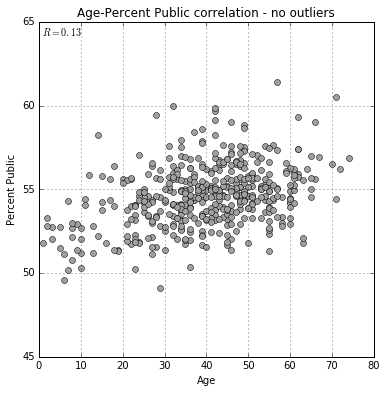

In [470]:
plt.show()

In [473]:
Age_nShared_correl_fig=draw_correlation_scatter(Age, perc_shared, figsize = (6, 6), xticks=None, yticks=None,\
                             xlim = None, ylim = None, r = True, ms=6, logd = False,\
                             xlab = 'Age', ylab = 'Percent Public', filename = 'Age-Percent Public correlation', title = 'Age-Percent Public correlation - no outliers',
                             color = "#a0a0a0", grid = True, dpi = 800, xticklabels = None, 
                             contour = False)

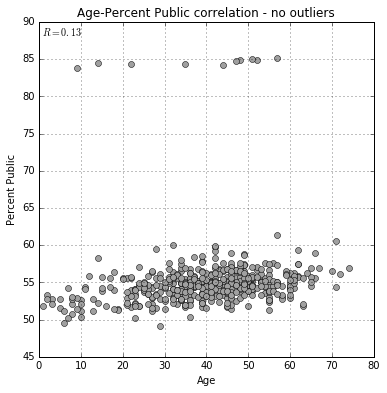

In [474]:
plt.show()

In [549]:
public_result_with_tags_df.mean()

perc_public_df_0          55.374975
perc_public_df_1           7.838814
public10perc_df_0         12.629619
public10perc_df_1          0.054489
public50perc_df_0          2.077668
public50perc_df_1          0.000000
public95perc_df_0          0.037685
public95perc_df_1          0.000000
meanSharedSamples_df_0    27.939816
meanSharedSamples_df_1     1.352501
cdr3PriToPub_df_0          1.098237
cdr3PriToPub_df_1          1.173858
cdr3PriToPub95_df_0        1.268857
cdr3PriToPub95_df_1             NaN
Age                       39.629707
dtype: float64

## sample-pair sharing statistics:

#### trials: 

In [554]:
df_file_names,samples_with_df=get_sample_with_dfs()

In [561]:
n=1
save_pickles=True
n_samples=3


unique_aa_prod_dict1={}
unique_aa_non_prod_dict1={}
for d in range(len(samples_with_df[:2])): ##***change here for more samples!***
    sample_name=samples_with_df[d]
    print n
    print sample_name
    sample_df, sample_df_prod, sample_df_non_prod=get_sample_data(sample_name, False)
    unique_aa_prod_dict1[sample_name]=sample_df_prod['aminoAcid'].unique()
    unique_aa_non_prod_dict1[sample_name]=sample_df_non_prod['aminoAcid'].unique()
    n+=1
    

1
HIP11513
getting sample data...
loading
finished getting sample data
2
HIP08200
getting sample data...
loading
finished getting sample data


In [565]:
n=1
save_pickles=True
n_samples=3


unique_aa_prod_dict2={}
unique_aa_non_prod_dict2={}
for d in samples_with_df[2:4]: ##***change here for more samples!***
    sample_name=d
    print n
    print sample_name
    sample_df, sample_df_prod, sample_df_non_prod=get_sample_data(sample_name, False)
    unique_aa_prod_dict2[sample_name]=sample_df_prod['aminoAcid'].unique()
    unique_aa_non_prod_dict2[sample_name]=sample_df_non_prod['aminoAcid'].unique()
    n+=1
    

1
HIP00769
getting sample data...
loading
finished getting sample data
2
HIP09122
getting sample data...
loading
finished getting sample data


In [566]:
unique_aa_prod_dict={}
unique_aa_prod_dict.update(unique_aa_prod_dict1)
unique_aa_prod_dict.update(unique_aa_prod_dict2)

In [567]:
print unique_aa_prod_dict.keys()

['HIP11513', 'HIP08200', 'HIP00769', 'HIP09122']


In [568]:
for key in  unique_aa_prod_dict.keys():
    print key
    print len(unique_aa_prod_dict[key])

HIP11513
242606
HIP08200
133947
HIP00769
186405
HIP09122
196567


In [569]:
from collections import OrderedDict
print unique_aa_prod_dict.keys()
unique_aa_prod_dict_sorted=OrderedDict(unique_aa_prod_dict)
print unique_aa_prod_dict_sorted.keys()

['HIP11513', 'HIP08200', 'HIP00769', 'HIP09122']
['HIP11513', 'HIP08200', 'HIP00769', 'HIP09122']


In [586]:
pairSharing=[]
#pd.DataFrame({'Sample1':[], 'Sample2':[], '# Common seqs':[],'# Total':[], '% shared':[]})

for i in range(len(unique_aa_prod_dict_sorted.keys())):
    sample1=unique_aa_prod_dict_sorted.keys()[i]
    sample1aa=set(unique_aa_prod_dict_sorted[sample1])
    for j in range(i+1,len(unique_aa_prod_dict_sorted.keys())):
        sample2=unique_aa_prod_dict_sorted.keys()[j]
        sample2aa=set(unique_aa_prod_dict_sorted[sample2])
        commonSeqsN=len(sample1aa&sample2aa)
        totalSeqs=len(sample1aa|sample2aa)
        percShared=(float(commonSeqsN)/totalSeqs)*100
        percSharedSample1=(float(commonSeqsN)/len(sample1aa))*100
        percSharedSample2=(float(commonSeqsN)/len(sample2aa))*100
        meandPercShared=float(percSharedSample1+percSharedSample2)/2
        
        pairSharing.append({'Sample1':sample1, 'Sample2':sample2, '# Common seqs':commonSeqsN,'# Total': totalSeqs,
                            '% shared':percShared,'%shared of sample1':percSharedSample1, '%shared of sample2':percSharedSample2,
                            'mean % shared': meandPercShared})
pairSharingDF=pd.DataFrame(pairSharing)
pairSharingDF.set_index(['Sample1','Sample2'], inplace=True)
        
    

In [587]:
pairSharingDF

# Common seqs  # Total  % shared  %shared of sample1  \
Sample1  Sample2                                                          
HIP11513 HIP08200           7706   368847  2.089213            3.176344   
         HIP00769          10212   418799  2.438401            4.209294   
         HIP09122          11238   427935  2.626100            4.632202   
HIP08200 HIP00769           6863   313489  2.189232            5.123668   
         HIP09122           7028   323486  2.172582            5.246851   
HIP00769 HIP09122           9448   373524  2.529422            5.068534   

                   %shared of sample2  mean % shared  
Sample1  Sample2                                      
HIP11513 HIP08200            5.753022       4.464683  
         HIP00769            5.478394       4.843844  
         HIP09122            5.717135       5.174668  
HIP08200 HIP00769            3.681768       4.402718  
         HIP09122            3.575371       4.411111  
HIP00769 HIP09122            4.806504       4.937519

#### real analysis:

loading dictionaries and merging:

In [15]:
#get all file names of the dictionaries created by the parallel jobs
filenames = [f for f in listdir('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/public_analysis/PairSharingCalc') if isfile(join('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/public_analysis/PairSharingCalc', f))]
#filenames = [datafile for datafile in filenames if datafile.startswith ('HIP') and datafile.endswith('.csv')]
#df_names=[re.sub('.csv', '', datafile) for datafile in filenames]
print filenames
print len(filenames)

['PairSharing_40_60', 'PairSharing_460_480', 'PairSharing_380_400', 'PairSharing_100_120', 'PairSharing_560_580', 'PairSharing_200_220', 'PairSharing_300_320', 'PairSharing_260_280', 'PairSharing_360_380', 'PairSharing_160_180', 'PairSharing_400_420', 'PairSharing_500_520', 'PairSharing_220_240', 'PairSharing_280_300', 'PairSharing_320_340', 'PairSharing_120_140', 'PairSharing_540_560', 'PairSharing_80_100', 'PairSharing_440_460', 'PairSharing_60_80', 'PairSharing_0_20', 'PairSharing_420_440', 'PairSharing_180_200', 'PairSharing_520_540', 'PairSharing_140_160', 'PairSharing_480_500', 'PairSharing_340_360', 'PairSharing_20_40', 'PairSharing_240_260']
29


In [16]:
#load each pair of dictionaries (prod+nonprod), unpack, and add ("update") to one big dictionary:


pairSharingDictProd={}
pairSharingDictNonProd={}
for file in filenames:
    with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/public_analysis/PairSharingCalc/%s' %file, 'rb') as f:
        twodicts=pickle.load(f)
    f.close()
    ProdDict=twodicts[0]
    NonProdDict=twodicts[1]
    pairSharingDictProd.update(ProdDict)
    pairSharingDictNonProd.update(NonProdDict)
print len(pairSharingDictProd)
print len(pairSharingDictNonProd)
    


573
573


In [17]:
#transform the dictionary into ordered dictionary (a tuple)

from collections import OrderedDict
pairSharingDictProd_sorted=OrderedDict(pairSharingDictProd)
pairSharingDictNonProd_sorted=OrderedDict(pairSharingDictNonProd)

In [ ]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/pairSharingDictProd_sorted', 'wb') as f:
        pickle.dump(pairSharingDictProd_sorted,f)
f.close()
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/pairSharingDictNonProd_sorted', 'wb') as f:
        pickle.dump(pairSharingDictNonProd_sorted,f)
f.close()

In [18]:
# load the age and gender data:

sample_tags=pd.read_table("/net//mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/SampleTags.tsv")
sample_tags['Sample']=sample_tags['Sample'].str.replace('.tsv','')
sample_tags.set_index('Sample', inplace=True)

In [ ]:
# run over all possible sample pairs, calculate sharing percentage, and also age differences and gender matches between samples:

pairSharingProd=[]
#pd.DataFrame({'Sample1':[], 'Sample2':[], '# Common seqs':[],'# Total':[], '% shared':[]})

for i in range(len(pairSharingDictProd_sorted.keys())):
    
    sample1=pairSharingDictProd_sorted.keys()[i]
    print (i,sample1)
    sample1aa=set(pairSharingDictProd_sorted[sample1])
    if sample1 in sample_tags.index:
        Age1=sample_tags.loc[sample1, 'Age']
        Gender1=sample_tags.loc[sample1, 'Gender']
    else:
        Age1=np.nan
        Gender1=np.nan
    for j in range(i+1,len(pairSharingDictProd_sorted.keys())):
        sample2=pairSharingDictProd_sorted.keys()[j]
        print (j,sample2)
        sample2aa=set(pairSharingDictProd_sorted[sample2])
        commonSeqsN=len(sample1aa&sample2aa)
        totalSeqs=len(sample1aa|sample2aa)
        percShared=(float(commonSeqsN)/totalSeqs)*100
        percSharedSample1=(float(commonSeqsN)/len(sample1aa))*100
        percSharedSample2=(float(commonSeqsN)/len(sample2aa))*100
        meandPercShared=float(percSharedSample1+percSharedSample2)/2
        if sample2 in sample_tags.index:
            Age2=sample_tags.loc[sample2, 'Age']
            Gender2=sample_tags.loc[sample2, 'Gender']
        else:
            Age2=np.nan
            Gender2=np.nan
        if sample1 in sample_tags.index and sample2 in sample_tags.index:
            AgeDif=abs(Age1-Age2)
            if Gender1==Gender2:
                GenderMatch=1
            else:
                GenderMatch=0
        else:
            AgeDif=np.nan
            GenderMatch=np.nan
            
        
        pairSharingProd.append({'Sample1':sample1, 'Sample2':sample2, '# Common seqs':commonSeqsN,'# Total': totalSeqs,
                            '% shared':percShared,'%shared of sample1':percSharedSample1, '%shared of sample2':percSharedSample2,
                            'mean % shared': meandPercShared, 'Age1': Age1, 'Age2': Age2, 'Age Difference': AgeDif, 
                            'Gender1': Gender1, 'Gender2':Gender2, 'Gender Match': GenderMatch})
pairSharingProdDF=pd.DataFrame(pairSharingProd)
pairSharingProdDF.set_index(['Sample1','Sample2'], inplace=True)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/pairSharingProdDF', 'wb') as f:
        pickle.dump(pairSharingProdDF,f)
f.close()

In [3]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/pairSharingProdDF', 'rb') as f:
        pairSharingProdDF=pickle.load(f)
f.close()

In [12]:
pairSharingProdDF.head()

# Common seqs  # Total  % shared  %shared of sample1  \
Sample1  Sample2                                                          
HIP14079 HIP02103          16387   575345  2.848204            5.453390   
         HIP14121          11813   479014  2.466107            3.931219   
         HIP12088          15654   550113  2.845597            5.209456   
         HIP10358          14735   517200  2.848995            4.903625   
         HIP05331           8657   407651  2.123630            2.880942   

                   %shared of sample2  Age Difference  Age1  Age2  \
Sample1  Sample2                                                    
HIP14079 HIP02103            5.626631             0.0  10.0  10.0   
         HIP14121            6.206426            39.0  10.0  49.0   
         HIP12088            5.901046            48.0  10.0  58.0   
         HIP10358            6.366578            22.0  10.0  32.0   
         HIP05331            7.474788            32.0  10.0  42.0   

                   Gender Match  Gender1  Gender2  mean % shared  
Sample1  Sample2                                                  
HIP14079 HIP02103           0.0   Female     Male       5.540010  
         HIP14121           0.0   Female     Male       5.068822  
         HIP12088           1.0   Female   Female       5.555251  
         HIP10358           1.0   Female   Female       5.635102  
         HIP05331           1.0   Female   Female       5.177865

In [19]:
# repeat for non-prod sequencese:

pairSharingNonProd=[]


for i in range(len(pairSharingDictNonProd_sorted.keys())):
    
    sample1=pairSharingDictNonProd_sorted.keys()[i]
    print (i,sample1)
    sample1aa=set(pairSharingDictNonProd_sorted[sample1])
    if sample1 in sample_tags.index:
        Age1=sample_tags.loc[sample1, 'Age']
        Gender1=sample_tags.loc[sample1, 'Gender']
    else:
        Age1=np.nan
        Gender1=np.nan
    for j in range(i+1,len(pairSharingDictNonProd_sorted.keys())):
        sample2=pairSharingDictNonProd_sorted.keys()[j]
        print (j,sample2)
        sample2aa=set(pairSharingDictNonProd_sorted[sample2])
        commonSeqsN=len(sample1aa&sample2aa)
        totalSeqs=len(sample1aa|sample2aa)
        percShared=(float(commonSeqsN)/totalSeqs)*100
        percSharedSample1=(float(commonSeqsN)/len(sample1aa))*100
        percSharedSample2=(float(commonSeqsN)/len(sample2aa))*100
        meandPercShared=float(percSharedSample1+percSharedSample2)/2
        if sample2 in sample_tags.index:
            Age2=sample_tags.loc[sample2, 'Age']
            Gender2=sample_tags.loc[sample2, 'Gender']
        else:
            Age2=np.nan
            Gender2=np.nan
        if sample1 in sample_tags.index and sample2 in sample_tags.index:
            AgeDif=abs(Age1-Age2)
            if Gender1==Gender2:
                GenderMatch=1
            else:
                GenderMatch=0
        else:
            AgeDif=np.nan
            GenderMatch=np.nan
            
        
        pairSharingNonProd.append({'Sample1':sample1, 'Sample2':sample2, '# Common seqs':commonSeqsN,'# Total': totalSeqs,
                            '% shared':percShared,'%shared of sample1':percSharedSample1, '%shared of sample2':percSharedSample2,
                            'mean % shared': meandPercShared, 'Age1': Age1, 'Age2': Age2, 'Age Difference': AgeDif, 
                            'Gender1': Gender1, 'Gender2':Gender2, 'Gender Match': GenderMatch})
pairSharingNonProdDF=pd.DataFrame(pairSharing)
pairSharingNonProdDF.set_index(['Sample1','Sample2'], inplace=True)

(0, 'HIP14079')
(1, 'HIP02103')
(2, 'HIP14121')
(3, 'HIP12088')
(4, 'HIP10358')
(5, 'HIP05331')
(6, 'HIP14071')
(7, 'HIP13754')
(8, 'HIP13757')
(9, 'HIP14072')
(10, 'HIP08827')
(11, 'HIP14074')
(12, 'HIP14077')
(13, 'HIP03502')
(14, 'HIP14170')
(15, 'HIP14172')
(16, 'HIP13610')
(17, 'HIP14175')
(18, 'HIP14176')
(19, 'HIP03111')
(20, 'HIP13992')
(21, 'HIP11989')
(22, 'HIP13741')
(23, 'HIP13994')
(24, 'HIP08389')
(25, 'HIP05551')
(26, 'HIP13956')
(27, 'HIP01836')
(28, 'HIP03592')
(29, 'HIP03505')
(30, 'HIP03591')
(31, 'HIP05437')
(32, 'HIP01298')
(33, 'HIP05434')
(34, 'HIP10480')
(35, 'HIP14240')
(36, 'HIP13926')
(37, 'HIP13962')
(38, 'HIP03378')
(39, 'HIP08890')
(40, 'HIP13920')
(41, 'HIP13518')
(42, 'HIP15685')
(43, 'HIP13515')
(44, 'HIP13511')
(45, 'HIP13929')
(46, 'HIP04611')
(47, 'HIP00775')
(48, 'HIP00773')
(49, 'HIP17793')
(50, 'HIP11711')
(51, 'HIP05559')
(52, 'HIP13720')
(53, 'HIP13722')
(54, 'HIP13198')
(55, 'HIP01255')
(56, 'HIP05524')
(57, 'HIP13352')
(58, 'HIP13355')
(59, 'H

NameError: name 'pairSharing' is not defined

In [ ]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/pairSharingNonProdDF', 'wb') as f:
        pickle.dump(pairSharingNonProdDF,f)
f.close()

calculate statistics and plot graphs

In [13]:
pairSharingProdDF.mean()

# Common seqs           8703.543124
# Total               371603.758796
% shared                   2.242893
%shared of sample1         4.774839
%shared of sample2         4.706677
Age Difference            15.989202
Age1                      39.537524
Age2                      39.722024
Gender Match               0.369631
mean % shared              4.740758
dtype: float64

In [14]:
pairSharingProdDF.sort(columns=['mean % shared'], ascending=False, inplace=True)

/usr/wisdom/python/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [15]:
pairSharingProdDF.groupby('Gender Match').agg([('N', 'count'),('mean', np.mean)])

# Common seqs              # Total         % shared            \
                         N         mean       N    mean        N      mean   
Gender Match                                                                 
0.0                  95170  8858.156657   95170  375578    95170  2.260791   
1.0                  55805  8736.636269   55805  372128    55805  2.251538   

             %shared of sample1           %shared of sample2            \
                              N      mean                  N      mean   
Gender Match                                                             
0.0                       95170  4.785658              95170  4.763155   
1.0                       55805  4.751984              55805  4.732070   

             Age Difference              Age1              Age2             \
                          N       mean      N       mean      N       mean   
Gender Match                                                                 
0.0                   59558  15.946942  78112  39.554985  75420  39.875537   
1.0                   54445  16.035430  54445  39.510827  54445  39.515254   

             mean % shared            
                         N      mean  
Gender Match                          
0.0                  95170  4.774406  
1.0                  55805  4.742027

In [4]:
pairSharingProd_corr_df,pairSharingProd_SigCorr_df=calc_sig_corr(pairSharingProdDF, 'mean % shared', 100)

calculating real correlations


myplots.py:325: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  res_corr_df.sort(columns='real_p', inplace=1)


0
start shuffling df
1
start shuffling df
2
start shuffling df
3
start shuffling df
4
start shuffling df
5
start shuffling df
6
start shuffling df
7
start shuffling df
8
start shuffling df
9
start shuffling df
10
start shuffling df
11
start shuffling df
12
start shuffling df
13
start shuffling df
14
start shuffling df
15
start shuffling df
16
start shuffling df
17
start shuffling df
18
start shuffling df
19
start shuffling df
20
start shuffling df
21
start shuffling df
22
start shuffling df
23
start shuffling df
24
start shuffling df
25
start shuffling df
26
start shuffling df
27
start shuffling df
28
start shuffling df
29
start shuffling df
30
start shuffling df
31
start shuffling df
32
start shuffling df
33
start shuffling df
34
start shuffling df
35
start shuffling df
36
start shuffling df
37
start shuffling df
38
start shuffling df
39
start shuffling df
40
start shuffling df
41
start shuffling df
42
start shuffling df
43
start shuffling df
44
start shuffling df
45
start shuffling d

In [5]:
print len(pairSharingProd_corr_df)
print len(pairSharingProd_SigCorr_df)

12
9


In [6]:
pairSharingProd_corr_df

real_p    real_r  r_perc_2_5  r_perc_97_5  \
column                                                                 
# Common seqs        0.000000e+00  0.910281   -0.003800     0.004845   
# Total              0.000000e+00  0.912511   -0.004135     0.005060   
% shared             0.000000e+00  0.852976   -0.004282     0.004323   
%shared of sample1   0.000000e+00  0.510420   -0.006165     0.005659   
%shared of sample2   0.000000e+00  0.467919   -0.004561     0.004883   
Age2                 0.000000e+00 -0.113223   -0.005719     0.004981   
mean % shared        0.000000e+00  1.000000   -0.004954     0.004605   
Age Difference      9.981170e-170  0.082109   -0.006166     0.005529   
Age1                4.078716e-166 -0.074165   -0.004599     0.005549   
Gender Match         2.050371e-17 -0.021850         NaN          NaN   
Gender1                       NaN       NaN         NaN          NaN   
Gender2                       NaN       NaN    1.000000     1.000000   

                    real_p_sig  real_p_sig_corrected  r_outof_CI  
column                                                            
# Common seqs                1                     1           1  
# Total                      1                     1           1  
% shared                     1                     1           1  
%shared of sample1           1                     1           1  
%shared of sample2           1                     1           1  
Age2                         1                     1           1  
mean % shared                1                     1           1  
Age Difference               1                     1           1  
Age1                         1                     1           1  
Gender Match                 1                     1           0  
Gender1                      0                     0           0  
Gender2                      0                     0           0

In [28]:
sample_tags['AgeGroup']=np.where(sample_tags['Age']<18,'young',np.where(sample_tags['Age']>55,'old',
                        np.where(sample_tags['Age'].isnull(),np.nan, 'adult')))

In [36]:
sample_tags['Gender']=sample_tags['Gender'].str.replace(' ','')
sample_tags.groupby('Gender').count()

Age  AgeGroup
Gender               
Female  224       250
Male    256       303

In [ ]:
pd.DataFrame.to_excel(excel_writer, sheet_name='Sheet1', na_rep='', float_format=None, columns=None, header=True, index=True, index_label=None, startrow=0, startcol=0, engine=None, merge_cells=True, encoding=None, inf_rep='inf', verbose=True)[source]

In [37]:
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles/sample_tags','wb') as f:
    pickle.dump(sample_tags,f)
f.close()

### generate dfs for the samples that currently have no dfs:

In [47]:
df_file_names,samples_with_df=get_sample_with_dfs()

In [ ]:
def get_sample_with_dfs():
    df_file_names = [f for f in listdir("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles") if isfile(join("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/Pickles", f))]
    df_file_names = [df_file for df_file in df_file_names if df_file.startswith ('sample_df_HIP')]
    samples_with_df=[s.replace("sample_df_", "") for s in df_file_names]
    return df_file_names,samples_with_df

In [48]:
sample_list=[f for f in listdir("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data") if isfile(join("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data", f))]

In [49]:
sample_list = [sample for sample in sample_list if sample.startswith ('HIP')]

In [50]:
sample_list=[s.replace(".tsv", "") for s in sample_list]
print len(sample_list)

587


In [51]:
without_df=[sample for sample in sample_list if not sample in samples_with_df]

In [52]:
print len(without_df)

0


In [53]:
print len(samples_with_df)

587


In [29]:
sample_df=pd.read_table("/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_demo_data/HIP13478.tsv")

In [31]:
sample_df_prod = sample_df[sample_df['sequenceStatus'] == 'In']

In [46]:
for sample_name in without_df:
    print sample_name
    sample_df, sample_df_prod, sample_df_non_prod=get_sample_data(sample_name, True)

HIP14041
getting sample data...
generating
finished getting sample data
HIP13780
getting sample data...
generating
finished getting sample data
HIP14022
getting sample data...
generating
finished getting sample data
HIP08345
getting sample data...
generating
finished getting sample data
HIP13996
getting sample data...
generating
finished getting sample data
HIP13932
getting sample data...
generating
finished getting sample data
HIP13383
getting sample data...
generating
finished getting sample data
HIP14089
getting sample data...
generating
finished getting sample data
